## Analysing the short answer grading data in regards to the relation between different columns

In this notebook we will explore the relationship between the model answer and the student answer on multiple levels:
<br></br>
- Length
- Similarity
- Keyword overlap
- Preplexity

# Imports

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import warnings
from pandarallel import pandarallel
import multiprocessing as mp
from functools import partial
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import os
from sklearn.preprocessing import MinMaxScaler

nltk.download("stopwords")
nltk.download("all")
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /home/amr/nltk_data...

[nltk_data]   Package stopwords is already up-to-date!

[nltk_data] Downloading collection 'all'

[nltk_data]    | 

[nltk_data]    | Downloading package abc to /home/amr/nltk_data...

[nltk_data]    |   Package abc is already up-to-date!

[nltk_data]    | Downloading package alpino to /home/amr/nltk_data...

[nltk_data]    |   Package alpino is already up-to-date!

[nltk_data]    | Downloading package averaged_perceptron_tagger to

[nltk_data]    |     /home/amr/nltk_data...

[nltk_data]    |   Package averaged_perceptron_tagger is already up-

[nltk_data]    |       to-date!

[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to

[nltk_data]    |     /home/amr/nltk_data...

[nltk_data]    |   Package averaged_perceptron_tagger_ru is already

[nltk_data]    |       up-to-date!

[nltk_data]    | Downloading package basque_grammars to

[nltk_data]    |     /home/amr/nltk_data...

[nltk_data]    |   Pack

# Data preperation and filtering

In [65]:
df = pd.read_csv("fffinal_version.csv")
df.drop(["Unnamed: 0"], axis=1, inplace=True)
df["model_answer"][df["model_answer"].isnull()] = " "
df["student_answer"][df["student_answer"].isnull()] = " "

In [67]:
# get the ratio of records that contain student answers
print(df[df["source"] == "short_answer_grading.csv"].shape[0] / df.shape[0])

0.0018474602734731681


In [68]:
def remove_stopwords(answer):
    stop_words = set(stopwords.words("english"))
    word_tokens = word_tokenize(answer)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    return " ".join(filtered_sentence)


def detect_short(answer):
    answer1 = answer.lower()
    if len(answer1.split()) > 3:
        return True
    else:
        return False


df_long_answer = df[
    df["model_answer"].apply(detect_short) | df["student_answer"].apply(detect_short)
]
df_long_answer.reset_index(drop=True, inplace=True)
df_long_answer.head()

,question,model_answer,student_answer,grade,source
0,are group 2 innate lymphoid cells ( illus ) in...,,"as illus are elevated in patients with crown, ...",NaN,finished_ori_pqaa_file.csv
1,does vagus nerve contribute to the development...,,neuronal signals via the hepatic vagus nerve c...,NaN,finished_ori_pqaa_file.csv
2,does gamma plan a induce sort in 1-dependent a...,,spa significantly inhibited mcf-7/add cells pr...,NaN,finished_ori_pqaa_file.csv
3,is methyl action of the fgfr2 gene associated ...,,we identified a novel biologically plausible c...,NaN,finished_ori_pqaa_file.csv
4,do tutor-infiltrating immune cell profiles and...,,breast cancer immune cell subpopulation profil...,NaN,finished_ori_pqaa_file.csv
...,...,...,...,...,...
791558,Who is Coli,,A dog used for dog fighting.,NaN,duorc.csv
791559,What was Valeria'a profession before she lost ...,,She was a Spanish supermodel.,NaN,duorc.csv
791560,What did the construction worker use to get Bu...,,A rock cutting saw.,NaN,duorc.csv
791561,Who does Bugs confront?,,A beefy construction worker.,NaN,duorc.csv


In [69]:
all_data = df["source"].value_counts()
long_data = df_long_answer["source"].value_counts()

In [70]:
# Get the number of long answers and all answers for each source
all_data = pd.DataFrame(all_data)
all_data.columns = ["all_data"]
long_data = pd.DataFrame(long_data)
long_data.columns = ["long_data"]
all_data = pd.merge(all_data, long_data, left_index=True, right_index=True)

# Question Length and Answer Length

In [73]:
# is there a correlation between the length of the answer and the length of the question?
df_long_answer["model_answer_length"] = df_long_answer["model_answer"].apply(
    lambda x: len(x.split())
)
df_long_answer["student_answer_length"] = df_long_answer["student_answer"].apply(
    lambda x: len(x.split())
)
df_long_answer["question_length"] = df_long_answer["question"].apply(
    lambda x: len(x.split())
)

In [74]:
# a dataframe to test the normality of the data
test = df_long_answer[["student_answer_length", "question_length"]][
    (df_long_answer["student_answer"] != " ")
]

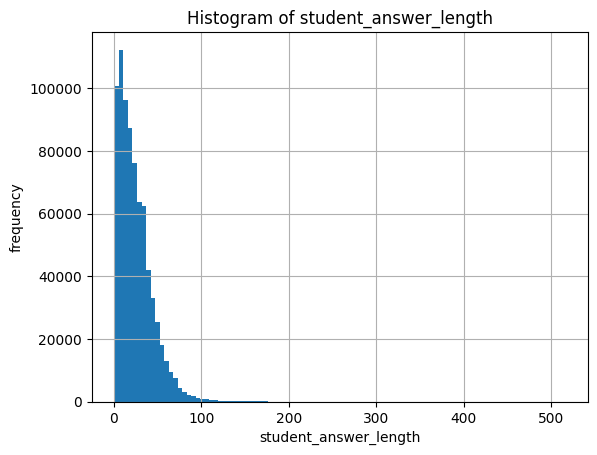

In [75]:
test["student_answer_length"].hist(bins=100)
plt.xlabel("student_answer_length")
plt.ylabel("frequency")
plt.title("Histogram of student_answer_length")
plt.show()

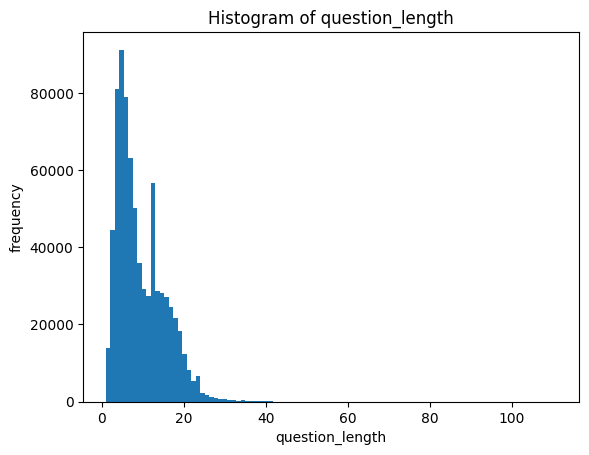

In [76]:
plt.hist(test["question_length"], bins=100)
plt.xlabel("question_length")
plt.ylabel("frequency")
plt.title("Histogram of question_length")
plt.show()

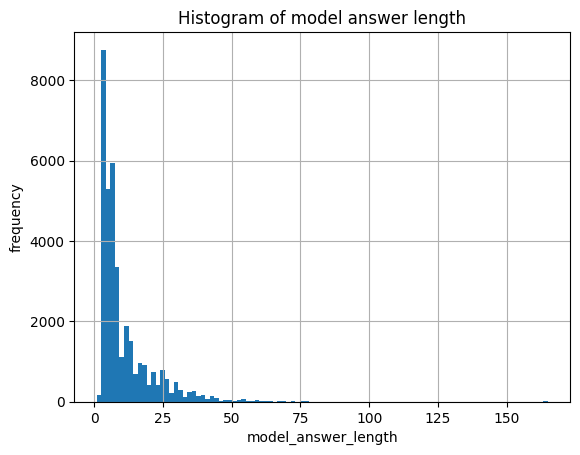

In [92]:
# test the normality of the model_answer_length
test_model = df_long_answer["model_answer_length"][
    df_long_answer["model_answer"] != " "
]
test_model.hist(bins=100)
plt.xlabel("model_answer_length")
plt.ylabel("frequency")
plt.title("Histogram of model answer length")
plt.show()

the logged question length stat =  ShapiroResult(statistic=0.9735522866249084, pvalue=0.0)


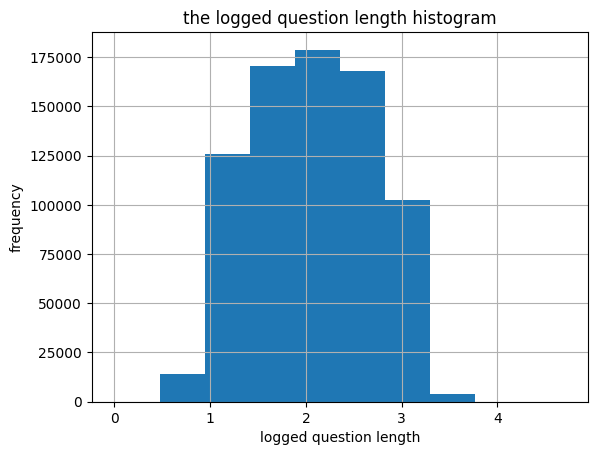

In [78]:
# test student answer length normality and question length normality
from scipy.stats import shapiro

# student_answer_length is right skewed, so we use log transformation
test["student_answer_length"] = np.log(test["student_answer_length"])
test["question_length"] = np.log(test["question_length"])
test["question_length"].hist()
print("the logged question length stat = ", shapiro(test["question_length"]))
# add plot title
plt.title("the logged question length histogram")
plt.xlabel("logged question length")
plt.ylabel("frequency")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


the logged student answer stat =  ShapiroResult(statistic=0.9744715094566345, pvalue=0.0)


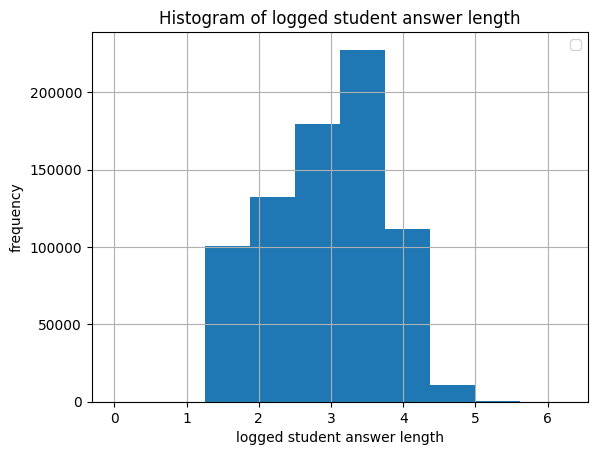

In [79]:
test["student_answer_length"].hist()
print("the logged student answer stat = ", shapiro(test["student_answer_length"]))
# add legend and title
plt.legend()
plt.title("Histogram of logged student answer length")
plt.xlabel("logged student answer length")
plt.ylabel("frequency")
plt.show()

In [81]:
# let's take each source and test the normality of the data for each source
# we will use the same test as above
test["source"] = df_long_answer["source"][df_long_answer["student_answer"] != " "]
for i in test["source"].unique():
    print("source = ", i)
    # filter the data for each source
    temp = test[test["source"] == i]
    # filter the data by 95th percentile to remove outliers
    temp = temp[
        (
            temp["student_answer_length"]
            < np.percentile(temp["student_answer_length"], 95)
        )
        & (
            temp["student_answer_length"]
            > np.percentile(temp["student_answer_length"], 5)
        )
    ]
    if len(temp) != 0:
        print(
            "the logged student answer stat = ", shapiro(temp["student_answer_length"])
        )

    temp = test[test["source"] == i]
    temp = temp[
        (temp["question_length"] < np.percentile(temp["question_length"], 95))
        & (temp["question_length"] > np.percentile(temp["question_length"], 5))
    ]
    print("the logged question length stat = ", shapiro(temp["question_length"]))

source =  finished_ori_pqaa_file.csv

the logged student answer stat =  ShapiroResult(statistic=0.9815640449523926, pvalue=0.0)

the logged question length stat =  ShapiroResult(statistic=0.9608739018440247, pvalue=0.0)

source =  finished_train_v2.1_file.csv

the logged student answer stat =  ShapiroResult(statistic=0.9720032215118408, pvalue=0.0)

the logged question length stat =  ShapiroResult(statistic=0.9115649461746216, pvalue=0.0)

source =  Tensorflow Dataset.csv

the logged question length stat =  ShapiroResult(statistic=0.7605346441268921, pvalue=0.0)

source =  finished_dev_v2.1_file.csv

the logged student answer stat =  ShapiroResult(statistic=0.972932755947113, pvalue=0.0)

the logged question length stat =  ShapiroResult(statistic=0.9126480221748352, pvalue=0.0)

source =  finished_ori_pqau_file.csv

the logged student answer stat =  ShapiroResult(statistic=0.9816626906394958, pvalue=0.0)

the logged question length stat =  ShapiroResult(statistic=0.9693314433097839, pv

Now we have our long answers which will result in meaningful relationships

In [112]:
# test relationship between model answer length and question length
from scipy.stats import spearmanr

corr = df_long_answer[["model_answer_length", "question_length"]][
    df_long_answer["model_answer"] != " "
].corr("spearman")
corr
testtt = df_long_answer[["model_answer_length", "question_length"]][
    (df_long_answer["model_answer"] != " ")
    & (df_long_answer["source"] == "short_answer_grading.csv")
]
spearmanr(testtt["model_answer_length"], testtt["question_length"])

SignificanceResult(statistic=0.004972794019187633, pvalue=0.8160855521173593)

In [98]:
# test for each source
for i in df_long_answer["source"].unique():
    print("source = ", i)
    temp = df_long_answer[df_long_answer["source"] == i]
    corr = temp[["model_answer_length", "question_length"]][
        temp["model_answer"] != " "
    ].corr("spearman")
    print(corr)

source =  finished_ori_pqaa_file.csv

                     model_answer_length  question_length

model_answer_length                  NaN              NaN

question_length                      NaN              NaN

source =  qa_7500.csv.csv

                     model_answer_length  question_length

model_answer_length             1.000000        -0.060336

question_length                -0.060336         1.000000

source =  finished_train_v2.1_file.csv

                     model_answer_length  question_length

model_answer_length                  NaN              NaN

question_length                      NaN              NaN

source =  SQUAD Dataset.csv

                     model_answer_length  question_length

model_answer_length             1.000000        -0.053754

question_length                -0.053754         1.000000

source =  Tensorflow Dataset.csv

                     model_answer_length  question_length

model_answer_length                  NaN              NaN

questi

In [83]:
# test relationship between student answer length and question length
corr = df_long_answer[["student_answer_length", "question_length"]][
    df_long_answer["student_answer"] != " "
].corr("spearman")
corr

,student_answer_length,question_length
student_answer_length,1.000000,0.456432
question_length,0.456432,1.000000


In [118]:
# lets test get the correlation between the grade and the difference in length between the model answer and the student answer
df_ans_mod = df_long_answer[
    (df_long_answer["model_answer"] != " ")
    & (df_long_answer["student_answer"] != " ")
    & (df_long_answer["source"] == "short_answer_grading.csv")
]
df_ans_mod["difference"] = (
    df_ans_mod["model_answer_length"] - df_ans_mod["student_answer_length"]
)
scaler = MinMaxScaler()
grade = df_ans_mod["grade"][
    df_ans_mod["source"] == "short_answer_grading.csv"
].values.reshape(-1, 1)
grade = scaler.fit_transform(grade)
df_ans_mod["grade"][
    df_ans_mod["source"] == "short_answer_grading.csv"
] = grade.squeeze()
# it's inituitive that the difference is also not normal since the student answer and model answer are not normal
corr = spearmanr(df_ans_mod["difference"], df_ans_mod["grade"])
print("corrr = ", corr)
from scipy.stats import spearmanr

# test the correlation between the grade and when the student answer is longer than the model answer
corr = spearmanr(
    df_ans_mod["difference"][df_ans_mod["difference"] > 0],
    df_ans_mod["grade"][df_ans_mod["difference"] > 0],
)
# the correlation between the grade and when the student answer is shorter than the model answer
print("corrr when diff is bigger than 0 = ", corr)
corr = spearmanr(
    df_ans_mod["difference"][df_ans_mod["difference"] < 0],
    df_ans_mod["grade"][df_ans_mod["difference"] < 0],
)
print("corrr when diff is smaller than 0 = ", corr)

corrr =  SignificanceResult(statistic=-0.1686308941203667, pvalue=1.958582973819678e-15)

corrr when diff is bigger than 0 =  SignificanceResult(statistic=-0.27487341682007416, pvalue=4.483661032761363e-15)

corrr when diff is smaller than 0 =  SignificanceResult(statistic=0.004755302768986457, pvalue=0.8634770513370131)


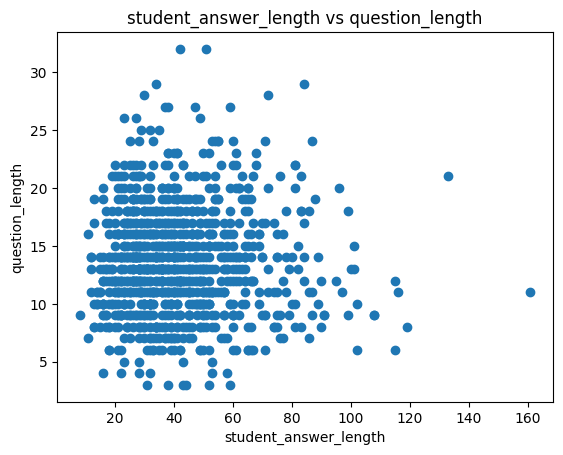

In [97]:
# let's test if correlation between the lengths of student answers and questions
x = df_long_answer[["student_answer_length", "question_length"]][
    (df_long_answer["student_answer"] != " ")
    & (df_long_answer["source"] == df_long_answer["source"].unique()[6])
].sample(1000)
st_ans_len = x["student_answer_length"]
ques_len = x["question_length"]
plt.scatter(st_ans_len, ques_len)
plt.xlabel("student_answer_length")
plt.ylabel("question_length")
plt.title("student_answer_length vs question_length")
plt.show()

In [113]:
# get the correlation between the question length and the student answer length according to the file source
for i in df_long_answer["source"].unique():
    corr = df_long_answer[["student_answer_length", "question_length"]][
        (df_long_answer["student_answer"] != " ") & (df_long_answer["source"] == i)
    ]
    print("source = ", i)
    print(spearmanr(corr["student_answer_length"], corr["question_length"]))

source =  finished_ori_pqaa_file.csv

SignificanceResult(statistic=0.049654450546948496, pvalue=2.4181578952331625e-115)

source =  qa_7500.csv.csv

SignificanceResult(statistic=nan, pvalue=nan)

source =  finished_train_v2.1_file.csv

SignificanceResult(statistic=-0.06447874265092675, pvalue=0.0)

source =  SQUAD Dataset.csv

SignificanceResult(statistic=nan, pvalue=nan)

source =  Tensorflow Dataset.csv

SignificanceResult(statistic=-0.007783393050436404, pvalue=0.43676373641200417)

source =  finished_dev_v2.1_file.csv

SignificanceResult(statistic=-0.029917865570743028, pvalue=6.289727856338615e-11)

source =  finished_ori_pqau_file.csv

SignificanceResult(statistic=0.03940457833062764, pvalue=1.7641495311624832e-22)

source =  wikiqa.csv

SignificanceResult(statistic=0.014399314787906486, pvalue=0.014328493560435952)

source =  short_answer_grading.csv

SignificanceResult(statistic=0.08599053378891837, pvalue=5.594224642856757e-05)

source =  finished_ori_pqal_file.csv

Significan

In [16]:
# it looks like the model answer doesn't correlate with the question length, or even correlates negatively
# but the student answer correlates positively with the question length. This means that the longer the question,
# the longer the student answer, but the shorter the model answer. This is probably because the model answer is a summary of the student answer,
# and the student answer correlates poisitively with the question length, which suggests for us to keep the questions as brief as possible to minimize the length of the student answer.

# Similarity between model and student answer

In [278]:
# import sentence transformer
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("bert-base-nli-mean-tokens")
model.to("cuda")

In [288]:
# get the similarity between the model answer and the student answer
from sklearn.metrics.pairwise import cosine_similarity
import torch


def get_similarity(answer1, answer2, model):
    answer1 = model.encode(answer1, convert_to_tensor=True)
    answer2 = model.encode(answer2, convert_to_tensor=True)
    answer1 = answer1.unsqueeze(0)
    answer2 = answer2.unsqueeze(0)
    cosine_scores = cosine_similarity(answer1.cpu(), answer2.cpu())
    return cosine_scores.item()


# example of how similarity works
get_similarity(
    "The United States invaded Iraq to stop mass destruction weapons",
    "The United States invaded Iraq to steal oil",
    model,
)

0.8836207985877991

In [287]:
# example of how similarity works
get_similarity(
    "The United States invaded Iraq to steal oil",
    "The United States intervened in Iraq with strategic objectives related to natural resources, specifically the acquisition of oil reserves.",
    model,
)

0.6619818806648254

In [290]:
# data that contains both model and student answers
model_student = df_long_answer[
    (df_long_answer["model_answer"] != " ") & (df_long_answer["student_answer"] != " ")
]

In [291]:
# get similarity between each pair and save it after excluding wikiqa.csv
all_sims = []
model_student = model_student[model_student["source"] != "wikiqa.csv"]
for i in zip(model_student["student_answer"], model_student["model_answer"]):
    all_sims.append(get_similarity(i[0], i[1], model))
model_student["similarity"] = all_sims

In [ ]:
described_mod = model_student["similarity"].describe()

In [197]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
sim_norm = scaler.fit_transform(
    np.power(model_student["similarity"], 2).values.reshape(-1, 1)
)
sim_norm = pd.Series(sim_norm.squeeze())
model_student["grade2"] = scaler.fit_transform(
    model_student["grade"].values.reshape(-1, 1)
)
# TEST FOR NORMALITY
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import anderson

stat, p = shapiro(sim_norm)
print("Statistics=%.3f, p=%.3f" % (stat, p))
stat, p = normaltest(sim_norm)
print("Statistics=%.3f, p=%.3f" % (stat, p))
stat, p = shapiro(model_student["grade2"])
print("Statistics=%.3f, p=%.3f" % (stat, p))

Statistics=0.991, p=0.000

Statistics=62.482, p=0.000

Statistics=0.787, p=0.000


Text(0.5, 1.0, 'similarity distribution')

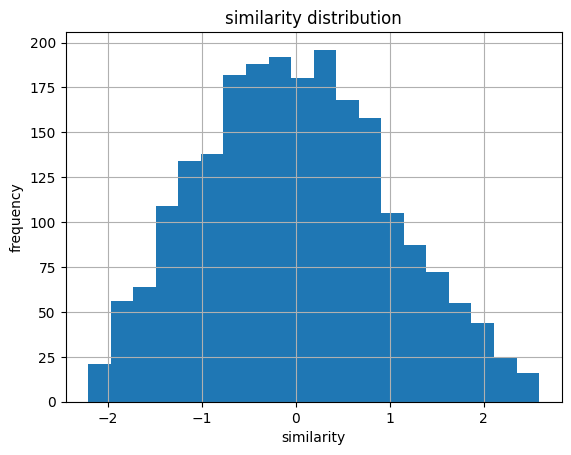

In [187]:
sim_norm.hist(bins=20)
# label the axes
plt.xlabel("similarity")
plt.ylabel("frequency")
plt.title("similarity distribution")

In [116]:
ranges = [
    [described_mod["min"], described_mod["25%"]],
    [described_mod["25%"], described_mod["50%"]],
    [described_mod["50%"], described_mod["75%"]],
    [described_mod["75%"], described_mod["max"]],
    [described_mod["min"], described_mod["50%"]],
    [described_mod["50%"], described_mod["max"]],
    [described_mod["min"], described_mod["75%"]],
    [described_mod["25%"], described_mod["max"]],
    [described_mod["min"], described_mod["max"]],
]
for i in ranges:
    print(
        "from ranges (",
        i[0],
        ", ",
        i[1],
        ") the correlation is",
        model_student[["similarity", "grade"]][
            (model_student["similarity"] > i[0]) & (model_student["similarity"] < i[1])
        ]
        .corr(method="spearman")
        .loc["similarity", "grade"],
        "with the len of",
        len(
            model_student[["similarity", "grade"]][
                (model_student["similarity"] > i[0])
                & (model_student["similarity"] < i[1])
            ]
        ),
    )

# compare the different

from ranges ( 0.019902389496564865 ,  0.5545990616083145 ) the correlation is 0.048176864942383615 with the len of 547

from ranges ( 0.5545990616083145 ,  0.6735664010047913 ) the correlation is 0.03673849773507105 with the len of 547

from ranges ( 0.6735664010047913 ,  0.7770454436540604 ) the correlation is 0.09642164558456062 with the len of 547

from ranges ( 0.7770454436540604 ,  0.9999998807907104 ) the correlation is 0.1837524848411093 with the len of 547

from ranges ( 0.019902389496564865 ,  0.6735664010047913 ) the correlation is 0.11227700742151762 with the len of 1094

from ranges ( 0.6735664010047913 ,  0.9999998807907104 ) the correlation is 0.26469106120322117 with the len of 1094

from ranges ( 0.019902389496564865 ,  0.7770454436540604 ) the correlation is 0.18619467207292298 with the len of 1641

from ranges ( 0.5545990616083145 ,  0.9999998807907104 ) the correlation is 0.2872654240615459 with the len of 1641

from ranges ( 0.019902389496564865 ,  0.999999880790710

0.10414027089182187

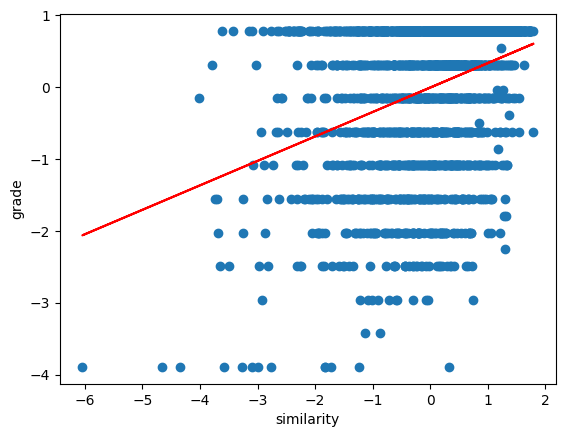

In [108]:
# create linear regression model to predict the grade based on the similarity
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# norm all data
X = model_student["similarity_skewed"].values.reshape(-1, 1)
y = model_student["grade"].values.reshape(-1, 1)
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
reg = LinearRegression().fit(X_train, y_train)
# draw the regression line
plt.scatter(X, y)
plt.plot(X, reg.predict(X), color="red")
plt.xlabel("similarity")
plt.ylabel("grade")
# get r not squared
reg.score(X_test, y_test)

In [ ]:
# get loss from the model
loss = model(
    torch.tensor(X_test).float().to("cuda"), torch.tensor(y_test).float().to("cuda")
).loss

In [92]:
model_student[["similarity_skewed", "grade"]].corr()

,similarity_skewed,grade
similarity_skewed,1.000000,0.337268
grade,0.337268,1.000000


<Axes: >

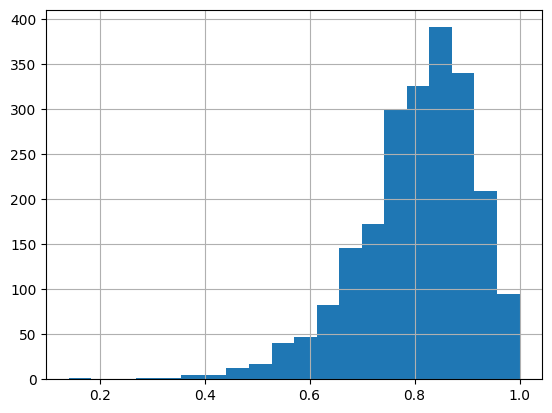

In [93]:
# skew the data to the right
model_student["similarity"].skew()
# make the data more skewed to the right
model_student["similarity_skewed"] = np.power(model_student["similarity"], 1 / 2)
model_student["similarity_skewed"].hist(bins=20)

Text(0.5, 0, 'similarity')

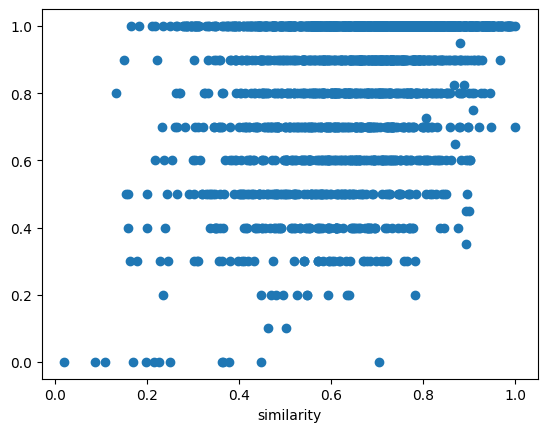

In [214]:
# scatter plot of similarity and grade
plt.scatter(model_student["similarity"], model_student["grade"])
plt.xlabel("similarity")
# there seem to be

# Keyword Extraction and Overlap

In [171]:
from transformers import AutoModel, AutoTokenizer
import torch

model = AutoModel.from_pretrained("gpt2", output_attentions=True)
model.to("cuda")
tokenizer = AutoTokenizer.from_pretrained("gpt2")

In [240]:
# Here we recycle an old project called Spotly to get the attention
def load_model_tokenizer(model_path):
    model = AutoModel.from_pretrained(model_path, output_attentions=True)
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    return model, tokenizer


def text_tokenization(input_text, model, tokenizer, device="cuda"):
    batch_encoding = tokenizer.encode_plus(input_text, return_tensors="pt")
    tokenized_inputs = batch_encoding["input_ids"]
    tokenized_inputs = tokenized_inputs[:, :512].to(device)
    outputs = model(tokenized_inputs)  # Run model
    attention = outputs[-1]  # Retrieve attention from model outputs
    return attention, tokenized_inputs, batch_encoding


def calculate_total_attention(attention):
    layer_sums = np.zeros((1, attention[0][0][0].shape[0]))
    for layer in attention:
        head_sums = np.zeros((1, layer[0][0].shape[1]))
        for head in layer[0].cpu():
            head = head.detach().numpy()
            head_sums += np.sum(head, axis=0)
        layer_sums += head_sums
    return layer_sums[0]


def filter_tokens(inputs, layer_sums, stop_words_tokens):
    ids = inputs[0].cpu().detach().numpy()
    out = [
        101,
        102,
        1010,
        1011,
        1012,
        100,
        1005,
        1025,
        1026,
        1027,
        1006,
        1007,
        1031,
        1032,
        1000,
    ]
    out.extend(stop_words_tokens)
    mask1 = np.ones(ids.shape, dtype=bool)
    for i in range(len(mask1)):
        if ids[i] in out:
            mask1[i] = 0
    ids = ids[mask1]
    layer_sums = layer_sums[mask1]
    return ids, layer_sums, mask1


def arbitrary_threshold(layer_sums, ids, threshold=70):
    # get 90 percentile of layer sums
    if layer_sums.size > 0:
        threshold = np.percentile(layer_sums, threshold)
    mask2 = np.zeros(layer_sums.shape, dtype=bool)
    for i, k in enumerate(layer_sums):
        if k >= threshold:
            mask2[i] = 1
    ids = ids[mask2]
    layer_sums = layer_sums[mask2]
    return ids, layer_sums, mask2


def get_word_indices(mask1, mask2):
    indices = np.arange(0, len(mask1))
    indices = indices[mask1]
    indices = indices[mask2]
    return indices


def get_corresponding_spans(batch_encoding, indices):
    all_spans = []
    for i in indices:
        lis = [batch_encoding.token_to_chars(i)[0], batch_encoding.token_to_chars(i)[1]]
        all_spans.append(lis)
    return all_spans


def spans_to_words(all_spans, input_text):
    words = []
    for i in all_spans:
        words.append(input_text[i[0] : i[1]])
    return words


def extract_attention_words(stop_words_tokens, model, input):
    attention, tokenized_inputs, batch_encoding = text_tokenization(
        input, model, tokenizer
    )
    layer_sums = calculate_total_attention(attention)
    ids, layer_sums, mask1 = filter_tokens(
        tokenized_inputs, layer_sums, stop_words_tokens
    )
    ids, layer_sums, mask2 = arbitrary_threshold(layer_sums, ids, 40)
    indices = get_word_indices(mask1, mask2)
    all_spans = get_corresponding_spans(batch_encoding, indices)
    words = spans_to_words(all_spans, input)
    return words


def strip_all(list_of_words):
    stripped = []
    for i in list_of_words:
        stripped.append(i.strip())
    return stripped

In [241]:
i = "This is the best day in my life i am not sure this code is working, can u check"
stop_words = set(stopwords.words("english"))
stop_words = list(stop_words)
stop_words_tokens = tokenizer.encode(" ".join(stop_words))

In [243]:
x = strip_all(extract_attention_words(stop_words_tokens, model, "queue"))
x

['queue']

In [244]:
data = df_long_answer[df_long_answer["source"] == "short_answer_grading.csv"]
data.reset_index(drop=True, inplace=True)
data["overlap_student_model"] = [0] * len(data)
data["overlap_student_question"] = [0] * len(data)
data["overlap_model_question"] = [0] * len(data)

for i in range(len(data)):
    model_answer = data["model_answer"][i]
    student_answer = data["student_answer"][i]
    question = data["question"][i]
    # extract the attention words from the model answer
    model_attention = strip_all(
        extract_attention_words(stop_words_tokens, model, model_answer)
    )
    answer_attention = strip_all(
        extract_attention_words(stop_words_tokens, model, student_answer)
    )
    question_attention = strip_all(
        extract_attention_words(stop_words_tokens, model, question)
    )

    # get the overlap between the model answer and the student answer
    overlap_student_model = len(
        set(model_attention).intersection(set(answer_attention))
    ) / len(set(model_attention).union(set(answer_attention)))
    overlap_student_question = len(
        set(question_attention).intersection(set(answer_attention))
    ) / len(set(question_attention).union(set(answer_attention)))
    overlap_model_question = len(
        set(question_attention).intersection(set(model_attention))
    ) / len(set(question_attention).union(set(model_attention)))
    data["overlap_student_model"][i] = overlap_student_model
    data["overlap_student_question"][i] = overlap_student_question
    data["overlap_model_question"][i] = overlap_model_question

Text(0.5, 1.0, 'overlap_student_question distribution')

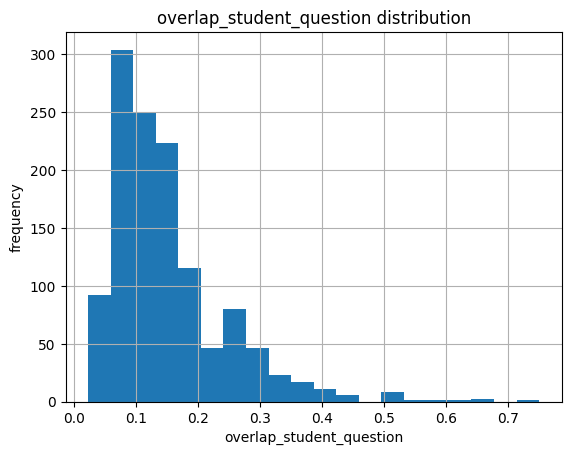

In [268]:
data["overlap_student_question"][data["overlap_student_question"] != 0].hist(bins=20)
plt.xlabel("overlap_student_question")
plt.ylabel("frequency")
plt.title("overlap_student_question distribution")

Text(0.5, 1.0, 'overlap_student_model distribution')

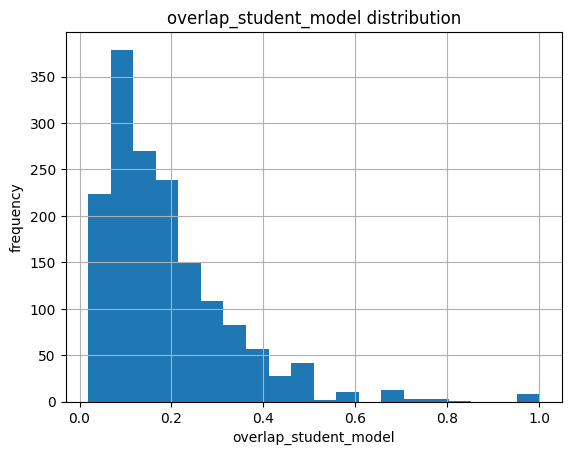

In [264]:
data["overlap_student_model"][data["overlap_student_model"] != 0].hist(bins=20)
plt.xlabel("overlap_student_model")
plt.ylabel("frequency")
plt.title("overlap_student_model distribution")

<Axes: >

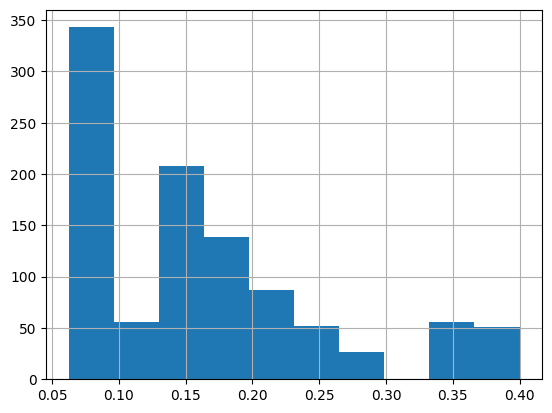

In [267]:
data["overlap_model_question"][data["overlap_model_question"] != 0].hist(bins=10)

In [263]:
# see how they correlate with the grade
data[
    [
        "overlap_student_model",
        "overlap_student_question",
        "overlap_model_question",
        "grade",
    ]
].corr("spearman")

,overlap_student_model,overlap_student_question,overlap_model_question,grade
overlap_student_model,1.000000,0.189594,0.237141,0.307459
overlap_student_question,0.189594,1.000000,0.366666,0.046986
overlap_model_question,0.237141,0.366666,1.000000,-0.028519
grade,0.307459,0.046986,-0.028519,1.000000


In [275]:
# apply log transformation to the overlap_student_model then see how it correlates with the grade
overlap_student_model_log = np.log(
    data["overlap_student_model"][data["overlap_student_model"] != 0]
)
corr = spearmanr(
    overlap_student_model_log, data["grade"][data["overlap_student_model"] != 0]
)
corr

SignificanceResult(statistic=0.2732118076325133, pvalue=4.4889975952233915e-29)

In [277]:
shapiro(overlap_student_model_log)

ShapiroResult(statistic=0.9920762777328491, pvalue=1.1969987667725945e-07)

In [272]:
shapiro(data["overlap_student_model_log"])

ShapiroResult(statistic=nan, pvalue=1.0)

In [318]:
model_student["overlaps_ms"] = data["overlap_student_model"].values
model_student["difference"] = df_ans_mod["difference"].values
import pingouin as pg

# get correlation between each of similarity and overlap and difference with partial correlation
print(spearmanr(model_student["similarity"], model_student["grade"]))
print(spearmanr(model_student["similarity"], model_student["difference"]))
print(spearmanr(model_student["similarity"], model_student["overlaps_ms"]))
print(
    pg.partial_corr(
        data=model_student,
        x="overlaps_ms",
        y="grade",
        covar="similarity",
        method="spearman",
    )
)
print(
    pg.partial_corr(
        data=model_student,
        x="similarity",
        y="grade",
        covar="overlaps_ms",
        method="spearman",
    )
)
print(
    pg.partial_corr(
        data=model_student,
        x="similarity",
        y="grade",
        covar="difference",
        method="spearman",
    )
)
print(
    pg.partial_corr(
        data=model_student,
        x="difference",
        y="similarity",
        covar="grade",
        method="spearman",
    )
)

SignificanceResult(statistic=0.3154916629442566, pvalue=8.276148008402719e-52)

SignificanceResult(statistic=0.06967583391537845, pvalue=0.0011033505874845336)

SignificanceResult(statistic=0.4479412659418091, pvalue=1.4903755008420868e-108)

             n         r         CI95%         p-val

spearman  2190  0.195824  [0.16, 0.24]  2.321934e-20

             n         r         CI95%         p-val

spearman  2190  0.208953  [0.17, 0.25]  5.088153e-23

             n         r        CI95%         p-val

spearman  2190  0.332804  [0.3, 0.37]  9.143694e-58

             n         r         CI95%         p-val

spearman  2190  0.131372  [0.09, 0.17]  6.841074e-10


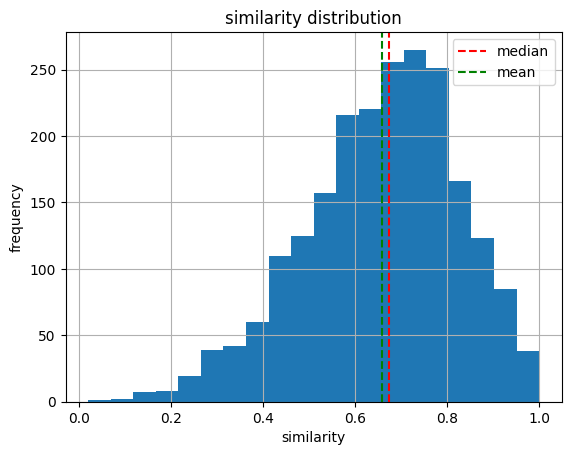

In [313]:
# similarity distribution
model_student["similarity"].hist(bins=20)
plt.xlabel("similarity")
plt.ylabel("frequency")
plt.title("similarity distribution")
# annotate mean and median
plt.axvline(model_student["similarity"].median(), color="red", linestyle="dashed")
plt.axvline(model_student["similarity"].mean(), color="green", linestyle="dashed")
plt.legend(["median", "mean"])
plt.show()

In [312]:
model_student["similarity"].describe()

count    2190.000000
mean        0.657703
std         0.165727
min         0.019902
25%         0.554599
50%         0.673566
75%         0.777045
max         1.000000
Name: similarity, dtype: float64

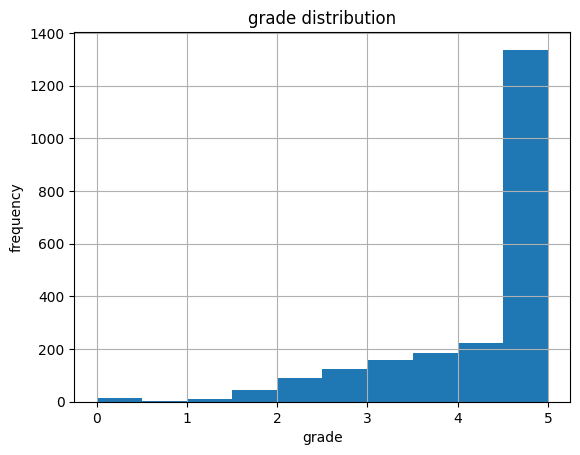

In [315]:
model_student["grade"].hist(bins=10)
plt.xlabel("grade")
plt.ylabel("frequency")
plt.title("grade distribution")
plt.show()

# Model and Student Answer preplexity

In [330]:
# get gpt2 to get a generative model that produces loss that can be turned into preplexity
import torch
from torch.nn import functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer

model = AutoModelForCausalLM.from_pretrained("gpt2")
model.to("cuda")
tokenizer = AutoTokenizer.from_pretrained("gpt2")

In [331]:
# example of two preplexity text samples
inputs = tokenizer(
    "ABC is a startup based in New York City and Paris", return_tensors="pt"
)
inputs.to("cuda")
loss = model(input_ids=inputs["input_ids"], labels=inputs["input_ids"]).loss
ppl = torch.exp(loss)
print(ppl)

inputs_wiki_text = tokenizer(
    "Generative Pretrained Transformer is an opensource artificial intelligence created by OpenAI in February 2019",
    return_tensors="pt",
)
inputs_wiki_text.to("cuda")
loss = model(
    input_ids=inputs_wiki_text["input_ids"], labels=inputs_wiki_text["input_ids"]
).loss
ppl = torch.exp(loss)
print(ppl)

tensor(29.4845, device='cuda:0', grad_fn=<ExpBackward0>)

tensor(211.8154, device='cuda:0', grad_fn=<ExpBackward0>)


In [ ]:
# get preplexity for each of the short answers
def get_ppl(answers, model):
    all_ppl = []
    for i in range(len(answers)):
        if i % 5000 == 0:
            print(i)
        inputs = tokenizer(answers.iloc[i], return_tensors="pt")
        # remove the unknown tokens
        inputs.to("cuda")
        loss = model(input_ids=inputs["input_ids"], labels=inputs["input_ids"]).loss
        ppl = torch.exp(loss)
        all_ppl.append(ppl.item())
    all_ppl = pd.Series(all_ppl)
    return all_ppl


answers = df_long_answer["student_answer"][
    (df_long_answer["student_answer"] != " ")
    & (df_long_answer["source"] == "short_answer_grading.csv")
]
short_ppl = get_ppl(answers, model)

In [ ]:
# get preplexity for each of the model answers
model_answers = df_long_answer["model_answer"][
    (df_long_answer["model_answer"] != " ")
    & (df_long_answer["source"] == "short_answer_grading.csv")
].drop_duplicates()
model_ppl = get_ppl(model_answers, model)

In [337]:
short_ppl.describe()

count      2185.000000
mean        702.557161
std        7831.901691
min           5.528841
25%          44.772720
50%          73.022820
75%         140.947784
max      246288.281250
dtype: float64

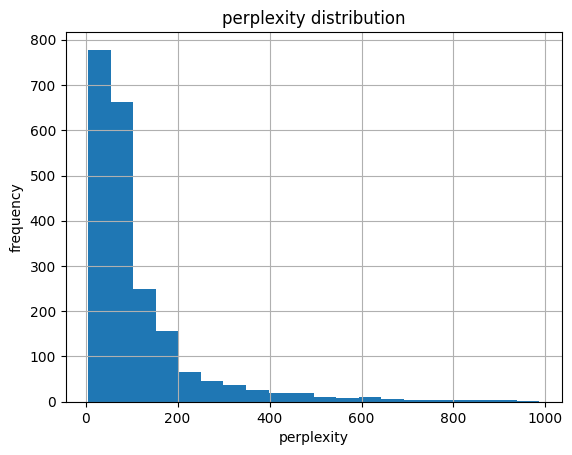

In [338]:
short_ppl[short_ppl < 1000].hist(bins=20)
plt.xlabel("perplexity")
plt.ylabel("frequency")
plt.title("perplexity distribution")
plt.show()

Text(0.5, 1.0, 'loss distribution')

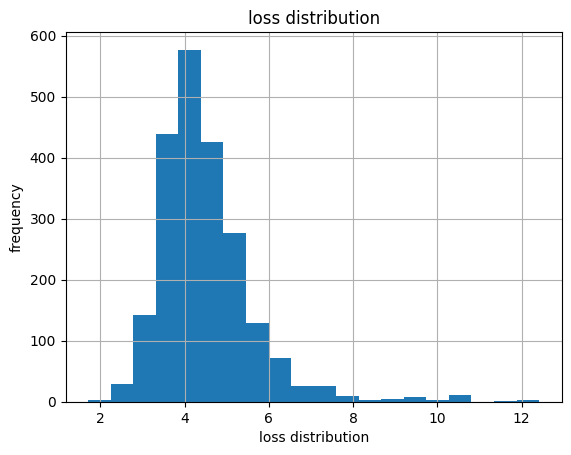

In [374]:
short_ppl_log = pd.Series(np.log(short_ppl))
short_ppl_log.hist(bins=20)
plt.xlabel("loss distribution")
plt.ylabel("frequency")
plt.title("loss distribution")

In [356]:
answers = df_long_answer[
    (df_long_answer["student_answer"] != " ")
    & (df_long_answer["source"] == "short_answer_grading.csv")
]
corr_grade_ppl = pd.DataFrame(
    {"grade": answers["grade"], "ppl_st": list(short_ppl), "ppl_mod": list(model_ppl)}
)
corr_grade_ppl.dropna(inplace=True)
corr_grade_ppl["ppl_diff"] = corr_grade_ppl["ppl_st"] - corr_grade_ppl["ppl_mod"]
print("correlation between grade and student answer perplexity")
print(spearmanr(corr_grade_ppl["grade"], corr_grade_ppl["ppl_st"]))
print("correlation between grade and model answer perplexity")
print(spearmanr(corr_grade_ppl["grade"], corr_grade_ppl["ppl_mod"]))
print("correlation between grade and difference in perplexity")
print(spearmanr(corr_grade_ppl["grade"], corr_grade_ppl["ppl_diff"]))
print("correlation between  perplexity iin student and model answer")
print(spearmanr(corr_grade_ppl["ppl_st"], corr_grade_ppl["ppl_mod"]))
print(
    spearmanr(
        corr_grade_ppl["grade"][corr_grade_ppl["ppl_diff"] > 0],
        corr_grade_ppl["ppl_diff"][corr_grade_ppl["ppl_diff"] > 0],
    )
)
print(
    spearmanr(
        corr_grade_ppl["grade"][corr_grade_ppl["ppl_diff"] < 0],
        corr_grade_ppl["ppl_diff"][corr_grade_ppl["ppl_diff"] < 0],
    )
)

SignificanceResult(statistic=-0.1160916030577078, pvalue=6.368919828847502e-08)

SignificanceResult(statistic=0.11827639624309469, pvalue=3.5758492760079145e-08)

SignificanceResult(statistic=-0.16410013427343814, pvalue=1.7093819028529063e-14)

SignificanceResult(statistic=0.15504380164209416, pvalue=4.4176307792626833e-13)

SignificanceResult(statistic=-0.11723636941783967, pvalue=1.665259770273618e-05)

SignificanceResult(statistic=-0.05018684804711968, pvalue=0.1525545363109813)


In [362]:
model_answers = df_long_answer["model_answer"][
    (df_long_answer["model_answer"] != " ")
    & (df_long_answer["source"] == "short_answer_grading.csv")
].drop_duplicates()
model_ppl = get_ppl(model_answers, model)

0


In [372]:
# correlation between the grade and the preplexity of the model answer
grade = df_long_answer[
    (df_long_answer["model_answer"] != " ")
    & (df_long_answer["source"] == "short_answer_grading.csv")
].drop_duplicates(subset=["model_answer"])
grade.reset_index(drop=True, inplace=True)
model_ppl.reset_index(drop=True, inplace=True)
grade["ppl"] = model_ppl
grade[["grade", "ppl"]].corr("spearman")

,grade,ppl
grade,1.000000,0.049598
ppl,0.049598,1.000000


In [ ]:
spearmanr(list(grade["grade"]), list(model_ppl))

In [119]:
corr_grade_ppl["grade"]

749832    3.5
749833    5.0
749834    4.0
749835    5.0
749836    3.0
         ... 
752017    5.0
752018    5.0
752019    5.0
752020    5.0
752021    5.0
Name: grade, Length: 2190, dtype: float64

In [121]:
corr_grade_ppl = corr_grade_ppl[corr_grade_ppl["grade"] < 4].dropna()
corr_grade_ppl["log_ppl"].mean()

4.736697276327902

In [130]:
corr_grade_ppl = pd.DataFrame(
    {"grade": answers["grade"], "log_ppl": list(short_ppl_log)}
)
grade = [0, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
avg = []
for i in grade:
    avg.append(corr_grade_ppl["log_ppl"][corr_grade_ppl["grade"] == i].mean())
pd.DataFrame({"grade": grade, "preplexity_avg": avg})

,grade,preplexity_avg
0,0.0,9.410798
1,1.0,4.885334
2,1.5,4.942107
3,2.0,4.687278
4,2.5,4.588401
5,3.0,4.599560
6,3.5,4.640900
7,4.0,4.455031
8,4.5,4.313957
9,5.0,4.409961


In [91]:
from scipy.stats import shapiro

stats, p = shapiro(short_ppl_log)
p

1.0

In [326]:
# test correlation significance
from scipy.stats import pearsonr
# correlation between the grade and the loss of the student answer
corr_grade_ppl = corr_grade_ppl.dropna()
corr, p = spearmanr(corr_grade_ppl["grade"], corr_grade_ppl["ppl"])
print("Pearsons correlation: %.3f" % corr)
# interpret the significance
alpha = 0.05
if p > alpha:
    print("Samples are uncorrelated (fail to reject H0) p=%.3f" % p)
else:
    print("Samples are correlated (reject H0) p=%.3f" % p)

NameError: name 'corr_grade_ppl' is not defined

Text(0.5, 1.0, 'loss distribution')

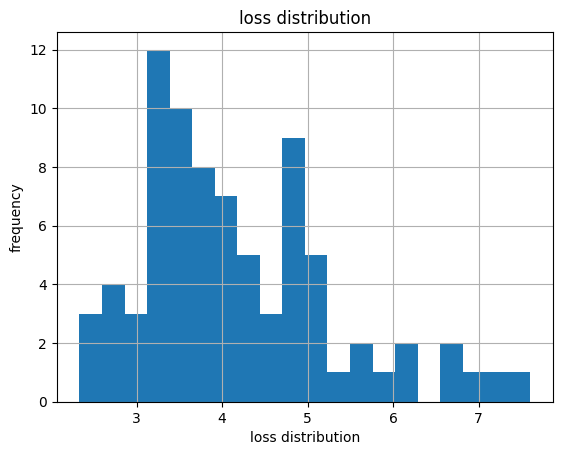

In [376]:
# get the loss again
model_ppl_log = pd.Series(np.log(model_ppl))
model_ppl_log.hist(bins=20)
plt.xlabel("loss distribution")
plt.ylabel("frequency")
plt.title("loss distribution")

In [79]:
z = df_long_answer["model_answer"][
    (df_long_answer["model_answer"] != " ")
    & (df_long_answer["source"] == "short_answer_grading.csv")
].drop_duplicates()
z = pd.DataFrame(pd.Series(z), columns=["model_answer"])
z["ppl"] = list(model_ppl)
z["ppl_log"] = list(model_ppl_log)
z["ppl"]
z.reset_index()

,index,model_answer,ppl,ppl_log
0,749832,to simulate the behaviour of portions of the d...,115.354134,4.748007
1,749860,the testing stage can influence both the codin...,64.196312,4.161946
2,749889,abstraction and re usability.,852.283752,6.747920
3,749918,at the main function.,151.934280,5.023448
4,749945,a location in memory that can store a value.,79.991302,4.381918
...,...,...,...,...
77,751897,a queue and de queue,2007.385742,7.604589
78,751914,use a circular array. keep the rear of the que...,44.500801,3.795507
79,751941,keep the rear of the queue pointing to the tai...,11.411443,2.434617
80,751995,push,NaN,NaN


In [83]:
# get the mdeian of the preplexity of the model answer for each question
pre_index = 0
previous = z.index[0]
short_med_per_q = []
for i in z.index[1:]:
    number = i - previous
    a = short_ppl_log[pre_index : number + pre_index].median()
    pre_index = number + pre_index
    short_med_per_q.append(a)